## Описание проекта HR-аналитика

Позади много уроков и заданий, и закрепить свои знания, как обычно, вы сможете в самостоятельном проекте. Это непростой проект, в котором от вас потребуется больше самостоятельности. Этапы работы описаны кратко, и вам понадобится декомпозировать задачи, то есть разделить их на более мелкие. Опирайтесь на знания об этапах анализа данных и машинного обучения из прошлых курсов.

Перейдём к задаче. HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

In [1]:
!pip install phik -q

!pip install scikit-learn==1.1.3 -q

!pip install shap -q

!pip install optuna -q

!pip install optuna-integration -q

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sns
from matplotlib import pyplot as plt

from phik.report import correlation_report, plot_correlation_matrix


from scipy import stats as st
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import(
    Ridge,
    LinearRegression,
    LogisticRegression,
) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    f1_score,
    make_scorer
)

from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             mean_absolute_error, 
                             mean_squared_error,
                             precision_score,
                             recall_score,
                             r2_score
                            )
    
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)

from optuna.integration import OptunaSearchCV
from optuna import distributions

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

import shap
from sklearn.feature_selection import SelectKBest, f_classif

from shap import Explanation, KernelExplainer
from shap.plots import waterfall, beeswarm

RANDOM_STATE = 42
TEST_SIZE = 0.25

### Шаг 1. Загрузка данных

In [3]:
try:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep=',')
    test_features = pd.read_csv('/datasets/test_features.csv', sep=',')
    test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep=',')

except:
    train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', sep=',')
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', sep=',')
    test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv', sep=',')

In [4]:
def data_info(data):
    pd.set_option('display.max_columns', None)
    display(data.head())
    display(data.describe(include='all'))
    data.info()

In [5]:
data_info(train_job_satisfaction_rate)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,3994,3996,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000.000000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,NaN
freq,NaN,1512,1894,2066,NaN,3880,3441,NaN,NaN,NaN
mean,544957.621000,NaN,NaN,NaN,3.718500,NaN,NaN,3.476500,33926.700000,0.533995
std,257883.104622,NaN,NaN,NaN,2.542513,NaN,NaN,1.008812,14900.703838,0.225327
min,100954.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,0.030000
25%,322836.750000,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,0.360000
50%,534082.500000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,0.560000
75%,771446.000000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,0.710000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [6]:
data_info(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
count,2000.000000,1998,1999,2000,2000.000000,2000,2000,2000.000000,2000.000000
unique,NaN,6,3,4,NaN,2,2,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN
freq,NaN,763,974,1043,NaN,1937,1738,NaN,NaN
mean,552765.213500,NaN,NaN,NaN,3.666500,NaN,NaN,3.526500,34066.800000
std,253851.326129,NaN,NaN,NaN,2.537222,NaN,NaN,0.996892,15398.436729
min,100298.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000
25%,339052.000000,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,22800.000000
50%,550793.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000
75%,765763.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [7]:
data_info(test_target)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Для исследования нам даны три датафрейма: train_job_satisfaction_rate - тренировочная выборка с характеристиками сотрудников компании; test_features - тестовая выборка с характеристиками сотрудников компании; test_target - с целевым признаком тестовой выборки. С типами данных все в порядке. В некоторых колонках есть пропуски. Размер тестовой выборки в два раза меньше тренировочной, соотношение - нормальное для анализа. 

### Шаг 2. Предобработка данных

Выведем долю пропущенных значений для каждого столбца датафреймов.

In [8]:
pd.DataFrame(train_job_satisfaction_rate.isna().mean()*100)

,0
id,0.00
dept,0.15
level,0.10
workload,0.00
employment_years,0.00
last_year_promo,0.00
last_year_violations,0.00
supervisor_evaluation,0.00
salary,0.00
job_satisfaction_rate,0.00


Есть 0.15% пропусков в столбце dept.

In [9]:
pd.DataFrame(test_features.isna().mean()*100)

,0
id,0.00
dept,0.10
level,0.05
workload,0.00
employment_years,0.00
last_year_promo,0.00
last_year_violations,0.00
supervisor_evaluation,0.00
salary,0.00


Есть 0.1% пропусков в столбце dept и 0.05% пропусков в столбце level.

In [10]:
pd.DataFrame(test_target.isna().mean()*100)

,0
id,0.0
job_satisfaction_rate,0.0


В датафрейме test_target пропщенных значений нет.

Заполнять пропуски будем в пайплайне.

Посмотрим, есть ли строки дубликаты в представленных данных.

In [11]:
train_job_satisfaction_rate.duplicated().sum()

0

In [12]:
test_features.duplicated().sum()

0

In [13]:
test_target.duplicated().sum()

0

Истинных дубликатов в представленных датафреймах нет.

In [14]:
train_job_satisfaction_rate['id'].duplicated().sum()

0

In [15]:
test_features['id'].duplicated().sum()

0

In [16]:
test_target['id'].duplicated().sum()

0

Строк с повторяющимися id в датафреймах нет.

Выведем уникальные категориальных значения признаков.

In [17]:
train_job_satisfaction_rate['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [18]:
train_job_satisfaction_rate['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [19]:
train_job_satisfaction_rate['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [20]:
train_job_satisfaction_rate['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [21]:
train_job_satisfaction_rate['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [22]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [23]:
test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [24]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [25]:
test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [26]:
test_features['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

В некоторых столбцах датафрейма test_features имеются пробелы. Заменим их на nan.

Есть 0.15% пропусков в столбце dept датафрейма train_job_satisfaction_rate и 0.1% пропусков в столбце dept и 0.05% пропусков в столбце level датафрейма test_features. В датафрейме test_target пропщенных значений нет. Истинных дубликатов в представленных датафреймах нет. Строк с повторяющимися id в датафреймах нет. В некоторых столбцах датафрейма test_features имеются пробелы. 

### Шаг 3. Исследовательский анализ данных

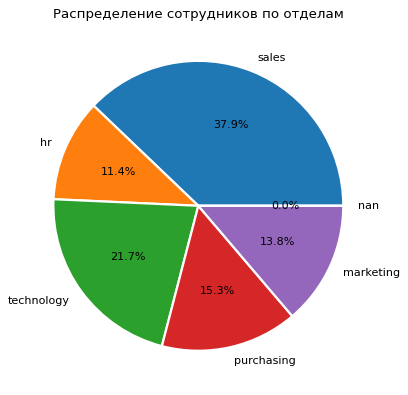

In [31]:
n1 = train_job_satisfaction_rate[train_job_satisfaction_rate['dept'] == 'sales']['id'].count()
n2 = train_job_satisfaction_rate[train_job_satisfaction_rate['dept'] == 'hr']['id'].count()
n3 = train_job_satisfaction_rate[train_job_satisfaction_rate['dept'] == 'technology']['id'].count()
n4 = train_job_satisfaction_rate[train_job_satisfaction_rate['dept'] == 'purchasing']['id'].count()
n5 = train_job_satisfaction_rate[train_job_satisfaction_rate['dept'] == 'marketing']['id'].count()
n6 = train_job_satisfaction_rate[train_job_satisfaction_rate['dept'] == 'nan']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2, n3, n4, n5, n6], labels=['sales', 'hr', 'technology', 'purchasing', 'marketing', 'nan'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение сотрудников по отделам')
plt.show()

Больше всего сотрудников работает в отделе sales, немного меньше - в technology. Остальные отделы представлены примерно одинаково.

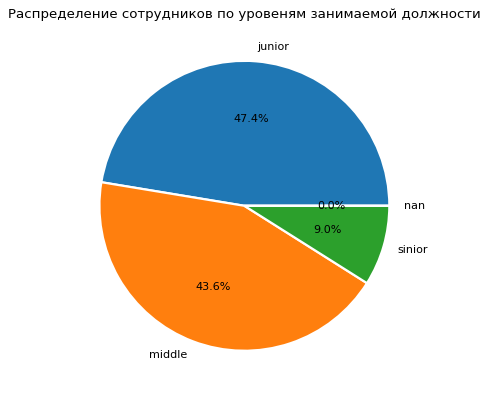

In [32]:
n1 = train_job_satisfaction_rate[train_job_satisfaction_rate['level'] == 'junior']['id'].count()
n2 = train_job_satisfaction_rate[train_job_satisfaction_rate['level'] == 'middle']['id'].count()
n3 = train_job_satisfaction_rate[train_job_satisfaction_rate['level'] == 'sinior']['id'].count()
n4 = train_job_satisfaction_rate[train_job_satisfaction_rate['level'] == 'purchasing']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2, n3, n4], labels=['junior', 'middle', 'sinior', 'nan'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение сотрудников по уровеням занимаемой должности')
plt.show()

Больше всего сотрудников занимают должности junior и middle.

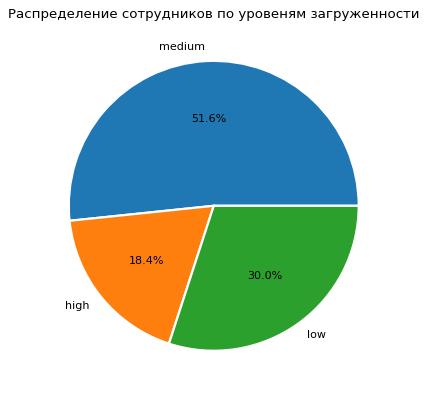

In [33]:
n1 = train_job_satisfaction_rate[train_job_satisfaction_rate['workload'] == 'medium']['id'].count()
n2 = train_job_satisfaction_rate[train_job_satisfaction_rate['workload'] == 'high']['id'].count()
n3 = train_job_satisfaction_rate[train_job_satisfaction_rate['workload'] == 'low']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2, n3], labels=['medium', 'high', 'low'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение сотрудников по уровеням загруженности')
plt.show()

В основном, уровень загруженности сотрудников - средний.

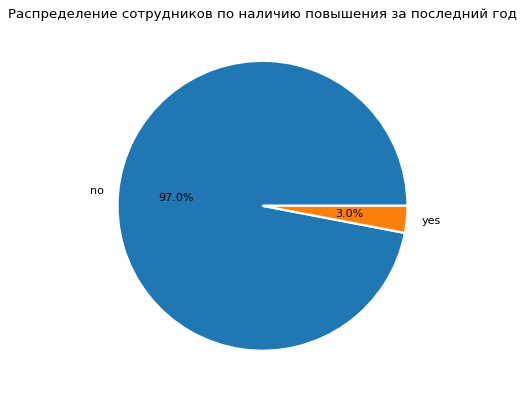

In [34]:
n1 = train_job_satisfaction_rate[train_job_satisfaction_rate['last_year_promo'] == 'no']['id'].count()
n2 = train_job_satisfaction_rate[train_job_satisfaction_rate['last_year_promo'] == 'yes']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['no', 'yes'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение сотрудников по наличию повышения за последний год')
plt.show()

В основном, за последний год сотрудников не повышали.

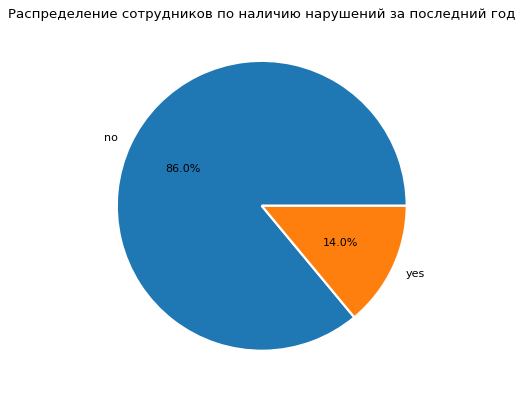

In [35]:
n1 = train_job_satisfaction_rate[train_job_satisfaction_rate['last_year_violations'] == 'no']['id'].count()
n2 = train_job_satisfaction_rate[train_job_satisfaction_rate['last_year_violations'] == 'yes']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['no', 'yes'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение сотрудников по наличию нарушений за последний год')
plt.show()

В большинстве случаев, сотрудники не нарушали трудовой договор.

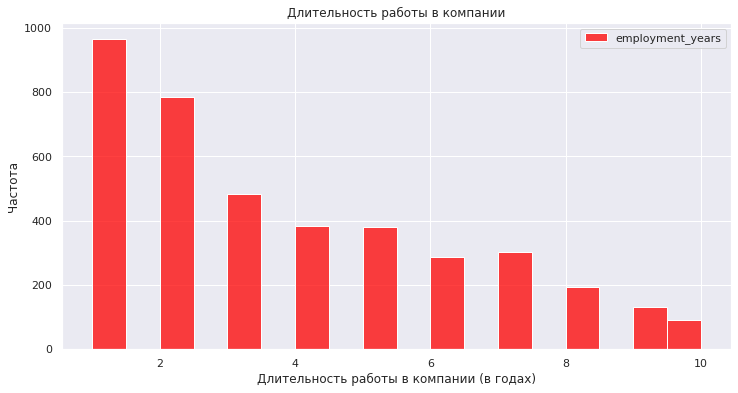

In [36]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=train_job_satisfaction_rate, x="employment_years", color="red", label="employment_years")

plt.ylabel('Частота')
plt.xlabel('Длительность работы в компании (в годах)')
plt.title('Длительность работы в компании')
plt.legend() 
plt.show()

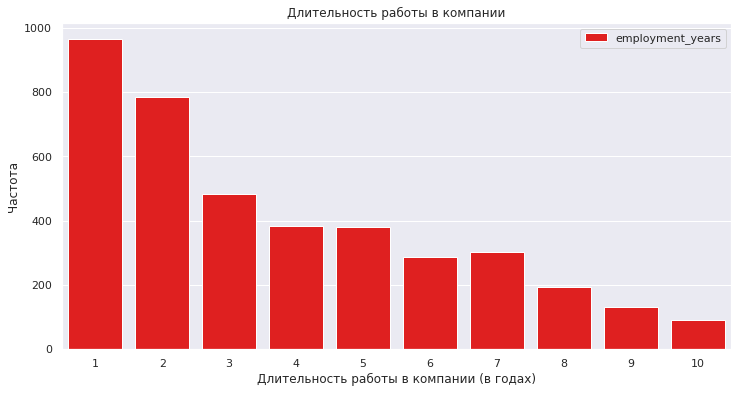

In [37]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=train_job_satisfaction_rate, x="employment_years", color="red", label="employment_years")

plt.ylabel('Частота')
plt.xlabel('Длительность работы в компании (в годах)')
plt.title('Длительность работы в компании')
plt.legend() 
plt.show()

В компании больше всего новичков, но есть и сотрудники, проработавшие больше 8 лет.

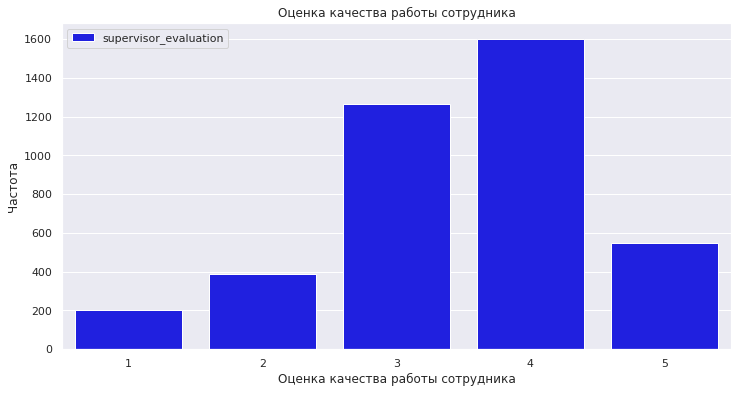

In [38]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=train_job_satisfaction_rate, x="supervisor_evaluation", color="blue", label="supervisor_evaluation")

plt.ylabel('Частота')
plt.xlabel('Оценка качества работы сотрудника')
plt.title('Оценка качества работы сотрудника')
plt.legend() 
plt.show()

Видно, что оценка качества работы сотрудника, которую дал руководитель, измеряется по пятибалльной системе. И, в основном, сотрудников оценивают на 4.

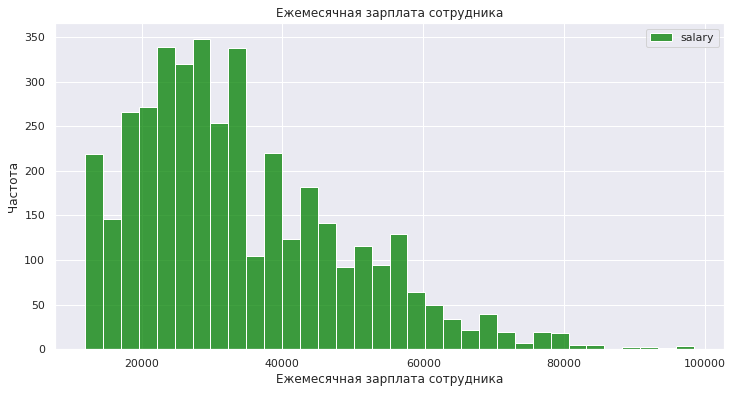

In [39]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=train_job_satisfaction_rate, x="salary", color="green", label="salary")

plt.ylabel('Частота')
plt.xlabel('Ежемесячная зарплата сотрудника')
plt.title('Ежемесячная зарплата сотрудника')
plt.legend() 
plt.show()

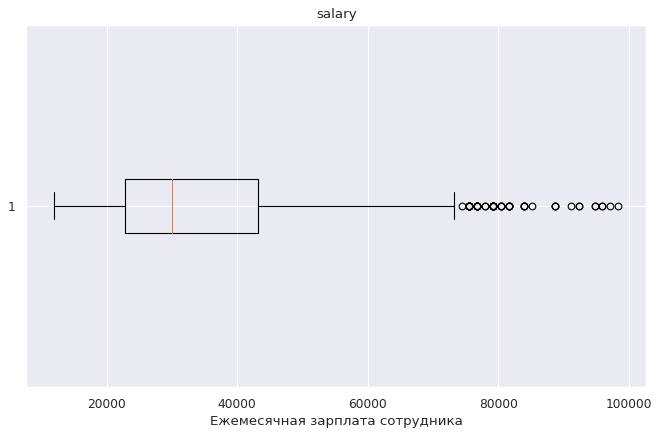

In [40]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(train_job_satisfaction_rate['salary'], vert=False)
plt.title('salary')
plt.xlabel('Ежемесячная зарплата сотрудника')
plt.show()

In [41]:
print('Среднее значение ежемесячной зарплаты сотрудника:', round(train_job_satisfaction_rate['salary'].mean(), 2))

Среднее значение ежемесячной зарплаты сотрудника: 33926.7


In [42]:
print('Медианное значение ежемесячной зарплаты сотрудника:', round(train_job_satisfaction_rate['salary'].median(), 2))

Медианное значение ежемесячной зарплаты сотрудника: 30000.0


Распределение заработной платы не симметричное, максимум сдвинут влево. Наблюдаются выбросы - значения больше 75000 руб. Среднеее значение (33927 руб.) немного выше медианного (30000 руб.). 

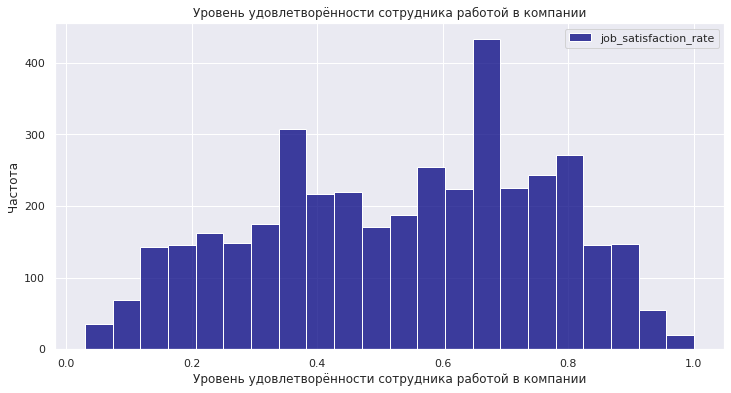

In [43]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=train_job_satisfaction_rate, x="job_satisfaction_rate", color="navy", label="job_satisfaction_rate")

plt.ylabel('Частота')
plt.xlabel('Уровень удовлетворённости сотрудника работой в компании')
plt.title('Уровень удовлетворённости сотрудника работой в компании')
plt.legend() 
plt.show()

Распределение уровня удовлетворённости сотрудника работой в компании - непрерывное, несимметричное, некоторые значения встречаются значительно чаще, чем другие.

Исследовательский анализ данных показал следующее.
Больше всего сотрудников работает в отделе sales, немного меньше - в technology. Остальные отделы представлены примерно одинаково.
Больше всего сотрудников занимают должности junior и middle.
В основном, уровень загруженности сотрудников - средний.
В основном, за последний год сотрудников не повышали.
В большинстве случаев, сотрудники не нарушали трудовой договор.
В компании больше всего новичков, но есть и сотрудники, проработавшие больше 8 лет.
Видно, что оценка качества работы сотрудника, которую дал руководитель, измеряется по пятибалльной системе. И, в основном, сотрудников оценивают на 4.
Распределение заработной платы не симметричное, максимум сдвинут влево. Наблюдаются выбросы - значения больше 75000 руб. Среднеее значение (33927 руб.) немного выше медианного (30000 руб.).
Распределение уровня удовлетворённости сотрудника работой в компании - непрерывное, несимметричное, некоторые значения встречаются значительно чаще, чем другие.


In [44]:
num_col = ['employment_years', 'salary']
cat_col = ['dept', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
ord_col = ['level', 'workload']

### Шаг 4. Корреляционный анализ

Для установления корреляций между целевым параметром - уровнем удовлетворённости сотрудника работой в компании и остальными признаками воспользуемся корреляцией Phi_K. Построим матрицу корреляций Phi_K.

In [45]:
data = train_job_satisfaction_rate.drop('id', axis=1)

In [46]:
data_phik = data.phik_matrix(interval_cols = num_col)
display(data_phik)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016509,0.037853,0.000000,0.000000,0.105495,0.282265,0.142102
level,0.000000,1.000000,0.419114,0.682773,0.101613,0.000000,0.000000,0.717630,0.181933
workload,0.016509,0.419114,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.115525
employment_years,0.037853,0.682773,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.331877
last_year_promo,0.000000,0.101613,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.433138
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.589007
supervisor_evaluation,0.105495,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.734837
salary,0.282265,0.717630,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.224015
job_satisfaction_rate,0.142102,0.181933,0.115525,0.331877,0.433138,0.589007,0.734837,0.224015,1.000000


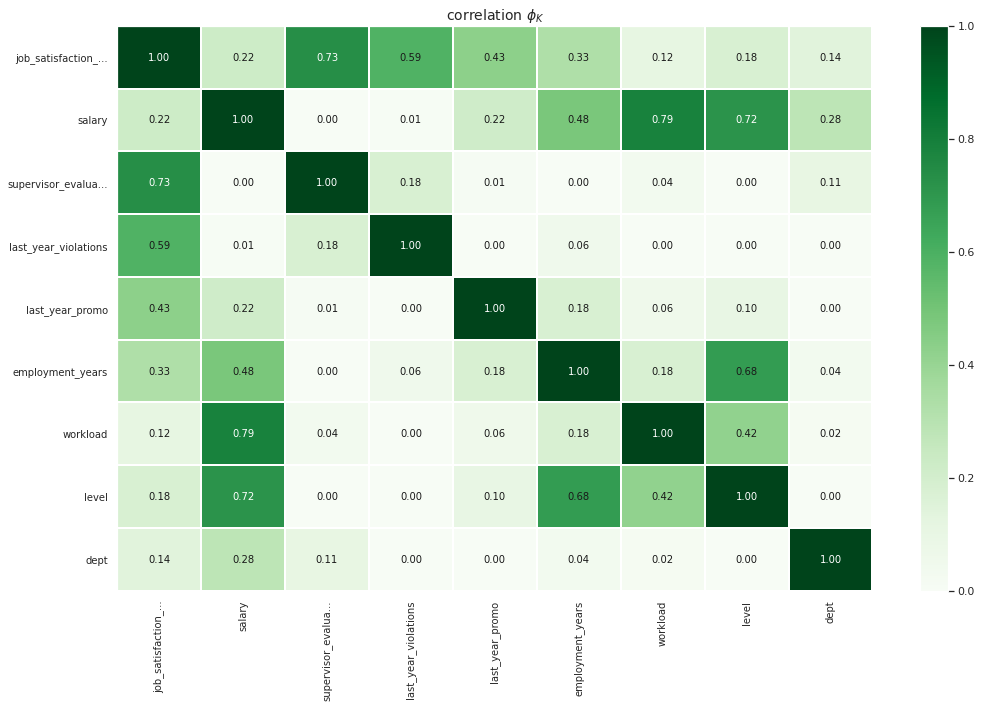

In [47]:
plot_correlation_matrix(data_phik.values, 
                        x_labels=data_phik.columns, 
                        y_labels=data_phik.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 10))

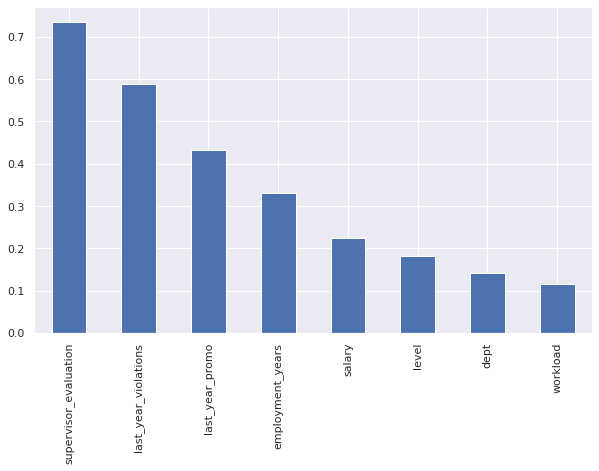

In [48]:
plt.figure(figsize=(10, 6))
_ = data_phik['job_satisfaction_rate'].sort_values(ascending=False)[1:].plot(kind='bar')

Самая высокая корреляция (коэффициент больше 0.7) между целевым параметром уровнем удовлетворённости сотрудника и  оценкой качества работы сотрудника, которую дал руководитель. С остальными признаками корреляция ниже. Следующие два признака с самыми высокими коэффициентами корреляции - нарушения сотрудником трудового договор за последний год и повышения за последний год.
Наблюдается высокая корреляция между следующими признаками: между рабочей загрузкой и зарплатой, между уровенем занимаемой должности и зарплатой. Однако коэффициеньы корреляции между этими признаками меньше 0.9, следовательно мультиколлинеарности не наблюдается.

Построим попарные диаграммы рассеяния.

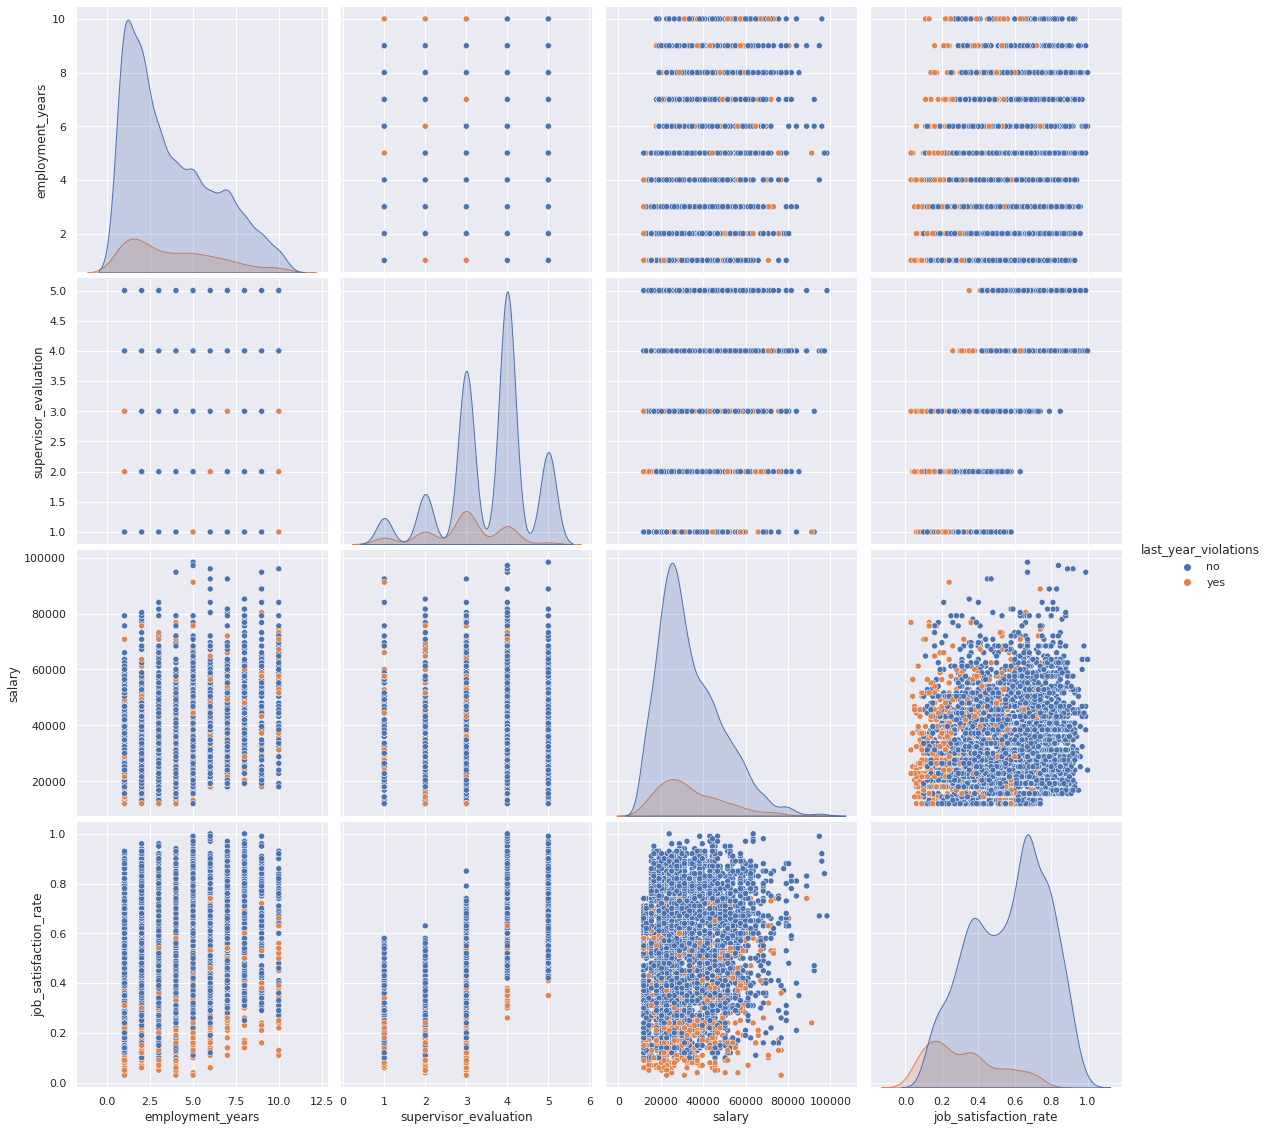

In [49]:
_ = sns.pairplot(data, hue='last_year_violations', height=4)

Из попарных диаграмм рассеяния видно, что хоть какая то зависимость наблюдается только между уровнем удволетворенности и оценкой качества работы. После разделения данных на две группы по признаку наличия нарушений трудового договора видно, что для нарушающих сотрудников есть зависимость (возможно, квадратичная) между уровнем удволетворенности и зарплатой. Еще наблюдается интересная закономерность: для работников с большим стажем (особенно 10 лет) нет зависимости между уровнем удволетворенности и наличием нарушений. Эти работники могут нарушать трудовой договор и при этом оставаться довольными своей работой. У работников с небольшим стажем все иначе. У них низкая удволетворенность коррелирует с наличием нарушений. Корреляционный анализ показывает, что нет линейной зависимости между целевым и остальными признаками. Это означает, что, скорее всего линейная модель нам не подойдет.

### Шаг 5. Подготовка данных

Разделим признаки на числовые, категориальные и порядковые.

Признак 'supervisor_evaluation' не будем обрабатывать. Перемещение признака 'last_year_promo' почему-то улучшило метрику модели.

In [50]:
num_col = ['employment_years', 'salary']
cat_col = ['dept', 'last_year_violations']
ord_col = ['level', 'workload', 'last_year_promo']

In [51]:
data.duplicated().sum()

245

In [52]:
data = data.drop_duplicates().reset_index(drop=True)

In [53]:
data.duplicated().sum()

0

In [54]:
X_train = data.drop(['job_satisfaction_rate'], axis=1)
y_train = data['job_satisfaction_rate']

In [55]:
# # создаём функцию для оценки качества модели
# def custom_metric(y_true, y_pred):
#     tmp = 2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_true))
#     len_ = np.count_nonzero(~np.isnan(tmp))
#     if len_ == 0 and np.nansum(tmp) == 0:
#         return 100
#     return 100 / len_ * np.nansum(tmp)

# # создаём пользовательскую метрику
# scorer = make_scorer(custom_metric) 

In [56]:
# Определение кастомной метрики SMAPE
def custom_metric(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    return np.mean(diff) * 100

# Преобразование SMAPE для GridSearchCV
scorer = make_scorer(custom_metric, greater_is_better=False)

In [57]:
# создаём пайплайн для подготовки признаков из списка cat_col: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

In [58]:
# cоздаём пайплайн для подготовки признаков из списка ord_col: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [59]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
)

Создадим два разных пайплайна для дерева решений и линейной модели, чтобы было удобнее подбирать параметры и оценивать результат.

In [60]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

param_grid = [
     #словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 50),
        'models__max_features': range(1, 50),
        'models__min_samples_split': range(2, 7),
        'models__min_samples_leaf': range(2, 7),
        #'models__min_weight_fraction_leaf': range(0, 1),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']  
    }
]

In [61]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_1= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

param_grid_1 = [
    # словарь для модели LinearRegression()
    {
        'preprocessor__num': [StandardScaler(),RobustScaler(), 'passthrough']  
    }
]

In [62]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=10
)

In [63]:
grid_search_1 = GridSearchCV(
    pipe_final_1,
    param_grid_1,
    cv=3,
    scoring=scorer,
    n_jobs=-1
)

### Шаг 6. Обучение моделей

In [64]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImpu...
                                                                          max_features=19,
                                                                          min_samples_leaf=2,
                                                                          min_samples_split=6,
                                                                          random_state=42)],
                                         'models__max_depth': range(1, 50),
                                         'models__max_features': range(1, 50),
                                         'models__min_samples_leaf': range(2, 7),
                                         'models__min_samples_split': range(2, 7),
                                         'preprocessor__num': [StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(custom_metric, greater_is_better=False))

In [65]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipe

In [66]:
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Метрика лучшей модели на кросс-валидации: -15.237945830761186


Наилучшей моделью оказалось дерево решений с параметрами max_depth=38, max_features=19, min_samples_leaf=2, min_samples_split=6. Метрика лучшей модели на кросс-валидации: 15.24.

**Я понимаю, что что-то не так с использованием этой модели. Попытка использовать дополнительные параметры (models__min_samples_split' и 'models__min_samples_leaf') приводит к еще большему увеличению метрики SMAPE. Также мне казалось, что для такого небольшого датафрейма лучше бы подошло разбиение на 3 фолда, однако, это тоже увеличило метрику. Выкидывание наименее важного признака тоже увеличило метрику. Помогите, пожалуйста! Что можно сделать, чтобы улучшить ситуацию?**

In [67]:
grid_search_1.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['dept',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer_be...
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['level',
                                                                          'workload',
                                                                          'last_year_promo']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['employment_years',
                                                                          'salary'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'preprocessor__num': [StandardScaler(),
                                                RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(custom_metric, greater_is_better=False))

In [68]:
print('Лучшая модель и её параметры:\n\n', grid_search_1.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipe

In [69]:
print ('Метрика лучшей модели на кросс-валидации:', grid_search_1.best_score_)

Метрика лучшей модели на кросс-валидации: -25.063182598924925


In [70]:
best_model = randomized_search.best_estimator_

In [71]:
y_pred = best_model.predict(X_train)

In [72]:
metric_train = scorer(best_model, X_train, y_train)

In [73]:
print ('Метрика лучшей модели на тестовой выборке:', metric_train)

Метрика лучшей модели на тестовой выборке: -8.786220704790564


Добавим к тестовой выборке целевой признак. Объединим две таблицы по id.

In [74]:
data_test = test_features.merge(test_target, on='id')

In [75]:
data_test

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,0.14
1997,305653,technology,junior,low,1,no,no,3,14400,0.11
1998,160233,technology,middle,low,8,no,no,1,32400,0.43


In [76]:
X_test = data_test.drop(['id', 'job_satisfaction_rate'], axis=1)

In [77]:
y_pred = best_model.predict(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [78]:
y_true = data_test['job_satisfaction_rate']

Рассчитаем метрику SMAPE на тестовых данных, используя в качестве модели дерево решений с подобранными параметрами. 

In [79]:
metric1 = scorer(best_model, X_test, y_true)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [80]:
print(metric1)

-13.720964831534019


In [81]:
best_model_lin = grid_search_1.best_estimator_

In [82]:
y_pred_lin = best_model_lin.predict(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Рассчитаем метрику SMAPE на тестовых данных, используя в качестве модели линейную модель. 

In [83]:
metric_lin = scorer(best_model_lin, X_test, y_true)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [84]:
print(metric_lin)

-23.56569625201904


Посмотрим на то, какие признаки оказались важными для лучшей модели - дерева решений.

In [85]:
best_model_1 = randomized_search.best_estimator_.named_steps['models']

In [86]:
prep = randomized_search.best_estimator_.named_steps['preprocessor']
X_train_pre = prep.transform(X_train)

In [87]:
col_names = prep.get_feature_names_out().tolist()

In [88]:
X_train_pre_df = pd.DataFrame(X_train_pre, columns=col_names)

In [89]:
feature_importances = pd.DataFrame(
    {
        'Feature': X_train_pre_df.columns,
        'Importance': best_model_1.feature_importances_
    })

In [90]:
print(feature_importances.sort_values('Importance', ascending=False))

                             Feature  Importance
10  remainder__supervisor_evaluation    0.662169
9                        num__salary    0.088453
8              num__employment_years    0.074752
4      ohe__last_year_violations_yes    0.053490
5                         ord__level    0.050238
6                      ord__workload    0.020324
2                    ohe__dept_sales    0.014536
7               ord__last_year_promo    0.012257
0                ohe__dept_marketing    0.009906
3               ohe__dept_technology    0.009828
1               ohe__dept_purchasing    0.004046


Видно, что с большим отрывом самым важным оказался признак - supervisor_evaluation. Остальные признаки значительно менее важные, самый неважный признак - dept.

Были обучены две модели: линейная модель LinearRegression() и дерево решений DecisionTreeRegressor(). Подбор параметров осуществлялся при помощи RandomizedSearchCV – для дерева решений. Лучшей оказалась модель – дерево решений с параметрами max_depth=38, max_features=19, min_samples_leaf=2, min_samples_split=6. Метрика SMAPE на кросс-валидации составила 15,2, на тестовой – 13,7. Для линейной модели етрика SMAPE на кросс-валидации составила 25, на тестовой - 27. Анализ важности признаков, показал, что с большим отрывом самым важным оказался признак - supervisor_evaluation. Остальные признаки значительно менее важные, самый неважный признак - dept.

### Шаг 6. Оформление выводов

Для исследования нам даны три датафрейма: train_job_satisfaction_rate - тренировочная выборка с характеристиками сотрудников компании; test_features - тестовая выборка с характеристиками сотрудников компании; test_target - с целевым признаком тестовой выборки. С типами данных все в порядке. В некоторых колонках есть пропуски. Размер тестовой выборки в два раза меньше тренировочной, соотношение - нормальное для анализа.

Есть 0.15% пропусков в столбце dept датафрейма train_job_satisfaction_rate и 0.1% пропусков в столбце dept и 0.05% пропусков в столбце level датафрейма test_features. В датафрейме test_target пропщенных значений нет. Истинных дубликатов в представленных датафреймах нет. Строк с повторяющимися id в датафреймах нет. В некоторых столбцах датафрейма test_features имеются пробелы.

Исследовательский анализ данных показал следующее. Больше всего сотрудников работает в отделе sales, немного меньше - в technology. Остальные отделы представлены примерно одинаково. Больше всего сотрудников занимают должности junior и middle. В основном, уровень загруженности сотрудников - средний. В основном, за последний год сотрудников не повышали. В большинстве случаев, сотрудники не нарушали трудовой договор. В компании больше всего новичков, но есть и сотрудники, проработавшие больше 8 лет. Видно, что оценка качества работы сотрудника, которую дал руководитель, измеряется по пятибалльной системе. И, в основном, сотрудников оценивают на 4. Распределение заработной платы не симметричное, максимум сдвинут влево. Наблюдаются выбросы - значения больше 75000 руб. Среднеее значение (33927 руб.) немного выше медианного (30000 руб.). Распределение уровня удовлетворённости сотрудника работой в компании - непрерывное, несимметричное, некоторые значения встречаются значительно чаще, чем другие.

Для установления корреляций между целевым параметром - уровнем удовлетворённости сотрудника работой в компании и остальными признаками использовалась корреляция Phi_K. Была построена матрица корреляций Phi_K. Самая высокая корреляция (коэффициент больше 0.7) между целевым параметром уровнем удовлетворённости сотрудника и оценкой качества работы сотрудника, которую дал руководитель. С остальными признаками корреляция ниже. Следующие два признака с самыми высокими коэффициентами корреляции - нарушения сотрудником трудового договор за последний год и повышения за последний год. Наблюдается высокая корреляция между следующими признаками: между рабочей загрузкой и зарплатой, между уровенем занимаемой должности и зарплатой. Однако коэффициеньы корреляции между этими признаками меньше 0.9, следовательно мультиколлинеарности не наблюдается.

Из попарных диаграмм рассеяния видно, что хоть какая то зависимость наблюдается только между уровнем удволетворенности и оценкой качества работы. После разделения данных на две группы по признаку наличия нарушений трудового договора видно, что для нарушающих сотрудников есть зависимость (возможно, квадратичная) между уровнем удволетворенности и зарплатой. Еще наблюдается интересная закономерность: для работников с большим стажем (особенно 10 лет) нет зависимости между уровнем удволетворенности и наличием нарушений. Эти работники могут нарушать трудовой договор и при этом оставаться довольными своей работой. У работников с небольшим стажем все иначе. У них низкая удволетворенность коррелирует с наличием нарушений. Корреляционный анализ показывает, что нет линейной зависимости между целевым и остальными признаками. Это означает, что, скорее всего линейная модель нам не подойдет.

Были обучены две модели: линейная модель LinearRegression() и дерево решений DecisionTreeRegressor(). Подбор параметров осуществлялся при помощи RandomizedSearchCV – для дерева решений. Лучшей оказалась модель – дерево решений с параметрами max_depth=38, max_features=19, min_samples_leaf=2, min_samples_split=6. Метрика SMAPE на кросс-валидации составила 15,2, на тестовой – 13,7. Для линейной модели етрика SMAPE на кросс-валидации составила 25, на тестовой - 27. Анализ важности признаков, показал, что с большим отрывом самым важным оказался признак - supervisor_evaluation. Остальные признаки значительно менее важные, самый неважный признак - dept.


## Задача 2: Предсказание увольнения сотрудника из компании

### Шаг 1. Загрузка данных

In [91]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv', sep=',')
    test_features = pd.read_csv('/datasets/test_features.csv', sep=',')
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv', sep=',')

except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv', sep=',')
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', sep=',')
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv', sep=',')

In [92]:
data_info(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
count,4000.000000,4000,4000,4000,4000.000000,4000,4000,4000.000000,4000.000000,4000
unique,NaN,5,3,3,NaN,2,2,NaN,NaN,2
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN,no
freq,NaN,1438,1949,2118,NaN,3887,3455,NaN,NaN,2872
mean,552099.283750,NaN,NaN,NaN,3.701500,NaN,NaN,3.474750,33805.800000,NaN
std,260158.031387,NaN,NaN,NaN,2.541852,NaN,NaN,1.004049,15152.415163,NaN
min,100222.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,NaN
25%,327785.750000,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,NaN
50%,546673.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000,NaN
75%,781497.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [93]:
data_info(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
count,2000.000000,1998,1999,2000,2000.000000,2000,2000,2000.000000,2000.000000
unique,NaN,6,3,4,NaN,2,2,NaN,NaN
top,NaN,sales,junior,medium,NaN,no,no,NaN,NaN
freq,NaN,763,974,1043,NaN,1937,1738,NaN,NaN
mean,552765.213500,NaN,NaN,NaN,3.666500,NaN,NaN,3.526500,34066.800000
std,253851.326129,NaN,NaN,NaN,2.537222,NaN,NaN,0.996892,15398.436729
min,100298.000000,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000
25%,339052.000000,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,22800.000000
50%,550793.000000,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,30000.000000
75%,765763.750000,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,43200.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [94]:
data_info(test_target_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


,id,quit
count,2000.000000,2000
unique,NaN,2
top,NaN,no
freq,NaN,1436
mean,552765.213500,NaN
std,253851.326129,NaN
min,100298.000000,NaN
25%,339052.000000,NaN
50%,550793.000000,NaN
75%,765763.750000,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Для исследования нам даны три датафрейма: train_quit - тренировочная выборка с характеристиками сотрудников компании; test_features - тестовая выборка с характеристиками сотрудников компании; test_target_quit - с целевым признаком тестовой выборки. С типами данных все в порядке. В некоторых колонках есть пропуски. Размер тестовой выборки в два раза меньше тренировочной, соотношение - нормальное для анализа.

### Шаг 2. Предобработка данных

Выведем долю пропущенных значений для каждого столбца датафреймов.

In [95]:
pd.DataFrame(train_quit.isna().mean()*100)

,0
id,0.0
dept,0.0
level,0.0
workload,0.0
employment_years,0.0
last_year_promo,0.0
last_year_violations,0.0
supervisor_evaluation,0.0
salary,0.0
quit,0.0


In [96]:
pd.DataFrame(test_features.isna().mean()*100)

,0
id,0.00
dept,0.10
level,0.05
workload,0.00
employment_years,0.00
last_year_promo,0.00
last_year_violations,0.00
supervisor_evaluation,0.00
salary,0.00


In [97]:
pd.DataFrame(test_target_quit.isna().mean()*100)

,0
id,0.0
quit,0.0


Пропуски есть только ы датафрейме test_features, который мы уже анализировали ранее.

Посмотрим, есть ли строки дубликаты в представленных данных.

In [98]:
train_quit.duplicated().sum()

0

In [99]:
test_features.duplicated().sum()

0

In [100]:
test_target_quit.duplicated().sum()

0

Истинных дубликатов в представленных датафреймах нет.

In [101]:
train_quit['id'].duplicated().sum()

0

In [102]:
test_features['id'].duplicated().sum()

0

In [103]:
test_target_quit['id'].duplicated().sum()

0

Строк с повторяющимися id в датафреймах нет.

Выведем уникальные значения признаков.

In [104]:
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [105]:
train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [106]:
train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [107]:
train_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [108]:
train_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [109]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

Поскольку был заново скачан датафрейм test_features, избавимся от пробелов в столбцах dept и workload: заменим их на nan.

In [110]:
#test_features['dept'] = test_features['dept'].replace(r'^\s*$', np.nan, regex=True)

In [111]:
#test_features['workload'] = test_features['workload'].replace(r'^\s*$', np.nan, regex=True)

С типами данных и значениями все в порядке.

Есть 0.1% пропусков в столбце dept и 0.05% пропусков в столбце level датафрейма test_features. В датафрейме test_target_quit пропущенных значений нет. Истинных дубликатов в представленных датафреймах нет. Строк с повторяющимися id в датафреймах нет. В некоторых столбцах датафрейма test_features имеются пробелы. Они были заменены на nan.

### Шаг 3. Исследовательский анализ данных

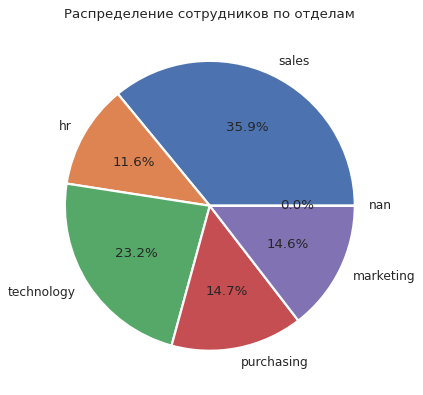

In [112]:
n1 = train_quit[train_quit['dept'] == 'sales']['id'].count()
n2 = train_quit[train_quit['dept'] == 'hr']['id'].count()
n3 = train_quit[train_quit['dept'] == 'technology']['id'].count()
n4 = train_quit[train_quit['dept'] == 'purchasing']['id'].count()
n5 = train_quit[train_quit['dept'] == 'marketing']['id'].count()
n6 = train_quit[train_quit['dept'] == 'nan']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2, n3, n4, n5, n6], labels=['sales', 'hr', 'technology', 'purchasing', 'marketing', 'nan'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение сотрудников по отделам')
plt.show()

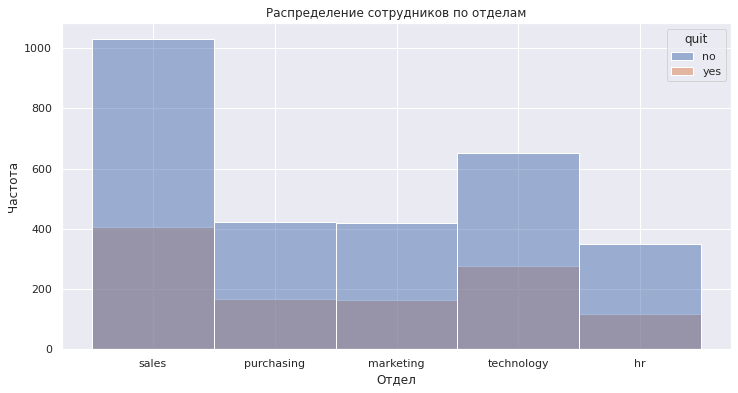

In [113]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=train_quit, x="dept", color="blue", hue="quit")

plt.ylabel('Частота')
plt.xlabel('Отдел')
plt.title('Распределение сотрудников по отделам')
#plt.legend() 
plt.show()

In [114]:
dep = train_quit[train_quit['quit'] == 'no']['dept'].value_counts(normalize=True)

In [115]:
dep1 = train_quit[train_quit['quit'] == 'no']['dept'].value_counts()/train_quit['dept'].value_counts()

In [116]:
dep_quit = train_quit[train_quit['quit'] == 'yes']['dept'].value_counts(normalize=True)

In [117]:
dep_quit1 = train_quit[train_quit['quit'] == 'yes']['dept'].value_counts()/train_quit['dept'].value_counts()

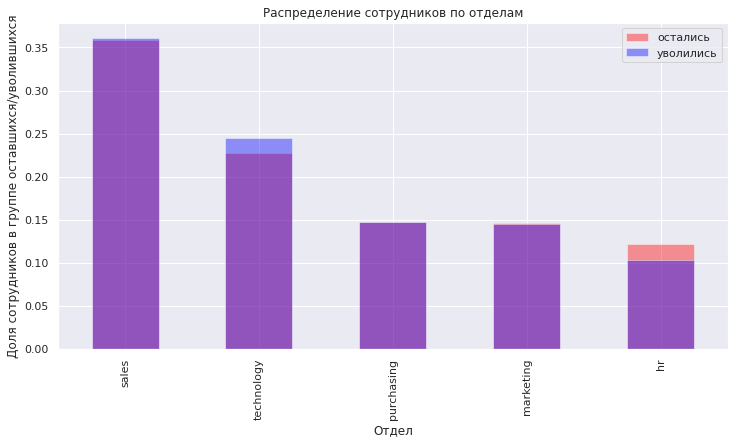

In [118]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")


dep.plot(kind='bar', color='red',alpha=0.4, label='остались')
dep_quit.plot(kind='bar', color='blue', alpha=0.4, label='уволились')

plt.ylabel('Доля сотрудников в группе оставшихся/уволившихся')
plt.xlabel('Отдел')
plt.title('Распределение сотрудников по отделам')
plt.legend() 
plt.show()

Видно, что распределение оставшихся сотрудников по отделам примерно такое же как и распределение уволившихся сотрудников.

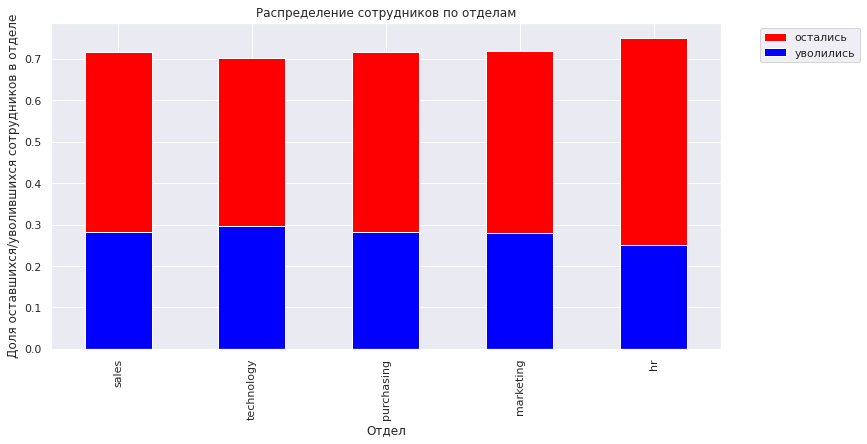

In [119]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

#sns.histplot(data=train_quit['dept'].value_counts(normalize=True), color="blue")
dep1.plot(kind='bar', color='red', label='остались')
dep_quit1.plot(kind='bar', color='blue', label='уволились')

plt.ylabel('Доля оставшихся/уволившихся сотрудников в отделе')
plt.xlabel('Отдел')
plt.title('Распределение сотрудников по отделам')
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left') 
plt.show()

Самая высокая доля уволившихся сотрудников - в отделе technology.

Больше всего сотрудников работает в отделе sales, немного меньше - в technology. Остальные отделы представлены примерно одинаково. Во всех отделах доля уволившихся сотрудников примерно одинакова. Больше всего сотрудников увольняется из отдела sales.

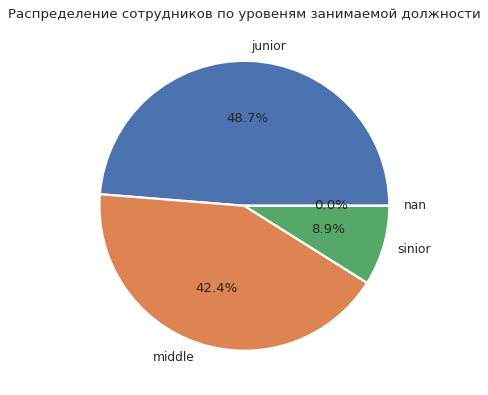

In [120]:
n1 = train_quit[train_quit['level'] == 'junior']['id'].count()
n2 = train_quit[train_quit['level'] == 'middle']['id'].count()
n3 = train_quit[train_quit['level'] == 'sinior']['id'].count()
n4 = train_quit[train_quit['level'] == 'purchasing']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2, n3, n4], labels=['junior', 'middle', 'sinior', 'nan'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение сотрудников по уровеням занимаемой должности')
plt.show()

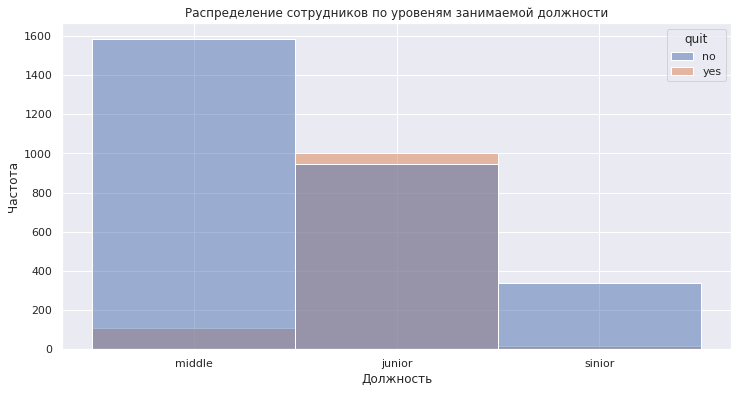

In [121]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=train_quit, x="level", color="blue", hue="quit")

plt.ylabel('Частота')
plt.xlabel('Должность')
plt.title('Распределение сотрудников по уровеням занимаемой должности')
#plt.legend() 
plt.show()

Больше всего сотрудников занимают должности junior и middle. Почти все уволившиеся занимали должность junior.

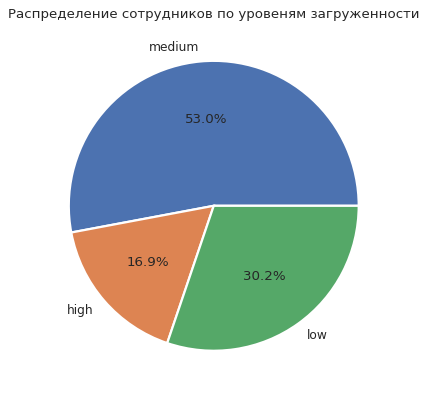

In [122]:
n1 = train_quit[train_quit['workload'] == 'medium']['id'].count()
n2 = train_quit[train_quit['workload'] == 'high']['id'].count()
n3 = train_quit[train_quit['workload'] == 'low']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2, n3], labels=['medium', 'high', 'low'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение сотрудников по уровеням загруженности')
plt.show()

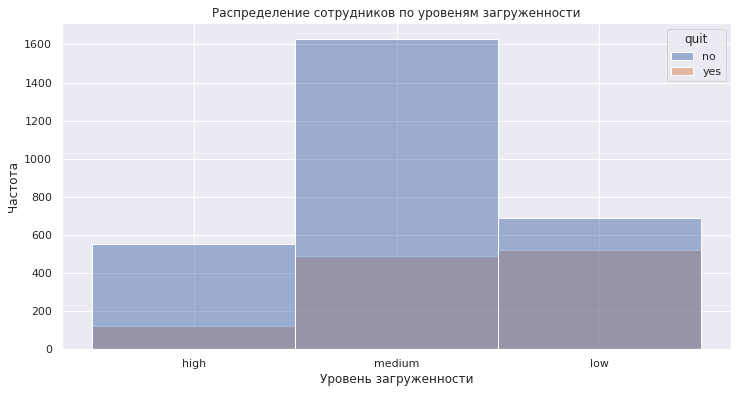

In [123]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=train_quit, x="workload", color="blue", hue="quit")

plt.ylabel('Частота')
plt.xlabel('Уровень загруженности')
plt.title('Распределение сотрудников по уровеням загруженности')
#plt.legend() 
plt.show()

В основном, уровень загруженности сотрудников - средний. Большинство уволившихся имели низкий уровень загрузки.

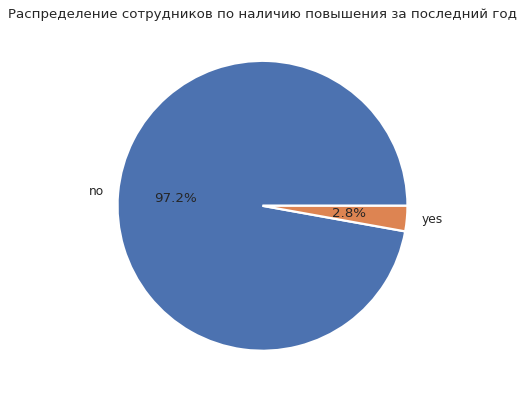

In [124]:
n1 = train_quit[train_quit['last_year_promo'] == 'no']['id'].count()
n2 = train_quit[train_quit['last_year_promo'] == 'yes']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['no', 'yes'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение сотрудников по наличию повышения за последний год')
plt.show()

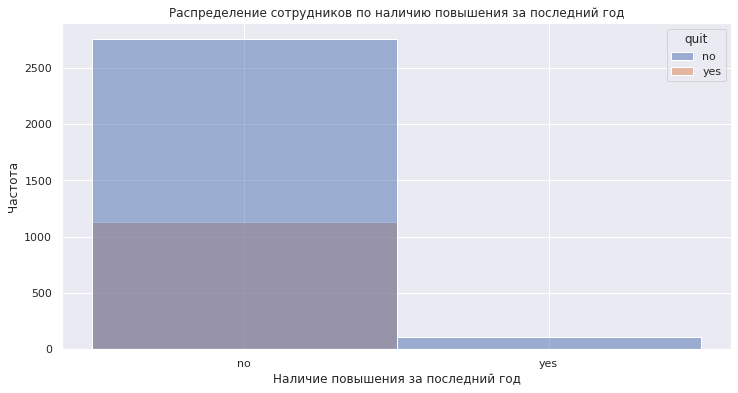

In [125]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=train_quit, x="last_year_promo", color="blue", hue="quit")

plt.ylabel('Частота')
plt.xlabel('Наличие повышения за последний год')
plt.title('Распределение сотрудников по наличию повышения за последний год')
#plt.legend() 
plt.show()

В основном, за последний год сотрудников не повышали. Среди тех, кого повышали, уволившихся нет.

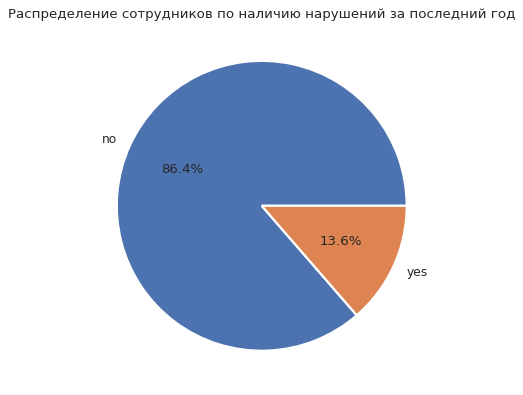

In [126]:
n1 = train_quit[train_quit['last_year_violations'] == 'no']['id'].count()
n2 = train_quit[train_quit['last_year_violations'] == 'yes']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['no', 'yes'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение сотрудников по наличию нарушений за последний год')
plt.show()

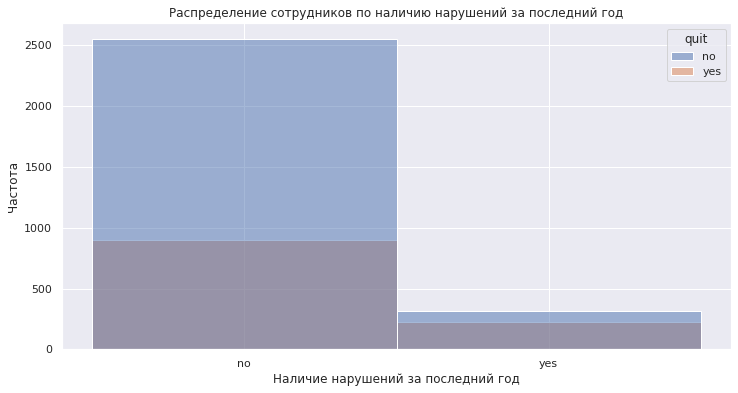

In [127]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=train_quit, x="last_year_violations", color="blue", hue="quit")

plt.ylabel('Частота')
plt.xlabel('Наличие нарушений за последний год')
plt.title('Распределение сотрудников по наличию нарушений за последний год')
#plt.legend() 
plt.show()

В большинстве случаев, сотрудники не нарушали трудовой договор. Однако относительная доля уволившихся сотрудников значительно выше среди тех, кто имел нарушения.

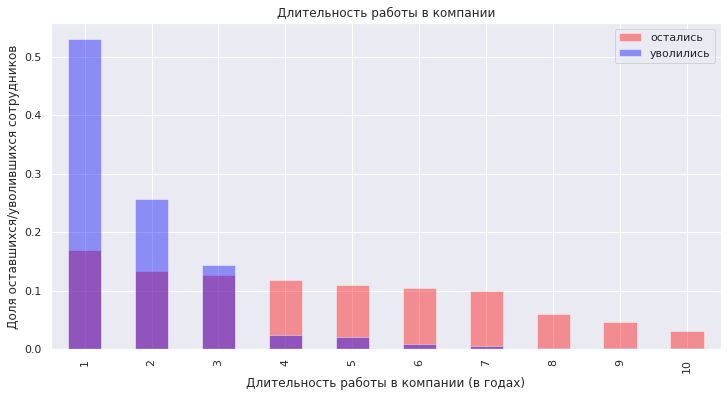

In [128]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")


train_quit[train_quit['quit'] == 'no']['employment_years'].value_counts(normalize=True).plot(kind='bar', color='red',alpha=0.4, label='остались')
train_quit[train_quit['quit'] == 'yes']['employment_years'].value_counts(normalize=True).plot(kind='bar', color='blue', alpha=0.4, label='уволились')

plt.ylabel('Доля оставшихся/уволившихся сотрудников')
plt.xlabel('Длительность работы в компании (в годах)')
plt.title('Длительность работы в компании')
plt.legend() 
plt.show()

В компании больше всего новичков, но есть и сотрудники, проработавшие больше 8 лет. Увольняются чаще всего сотрудники с маленьким стажем - меньше 4 лет. Больше всего увольняются в первый год работы.

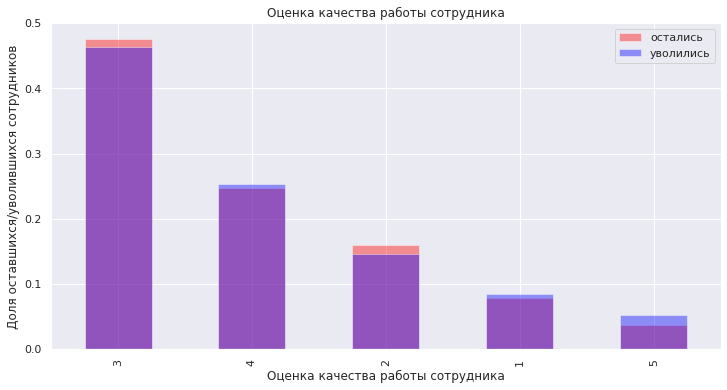

In [129]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")


train_quit[train_quit['quit'] == 'no']['supervisor_evaluation'].value_counts(normalize=True).plot(kind='bar', color='red',alpha=0.4, label='остались')
train_quit[train_quit['quit'] == 'yes']['supervisor_evaluation'].value_counts(normalize=True).plot(kind='bar', color='blue', alpha=0.4, label='уволились')

plt.ylabel('Доля оставшихся/уволившихся сотрудников')
plt.xlabel('Оценка качества работы сотрудника')
plt.title('Оценка качества работы сотрудника')
plt.legend() 
plt.show()

Видно, что оценка качества работы сотрудника, которую дал руководитель, измеряется по пятибалльной системе. И, в основном, сотрудников оценивают на 3. Увольняются чаще всего сотрудники с  оценкой работы -  3.

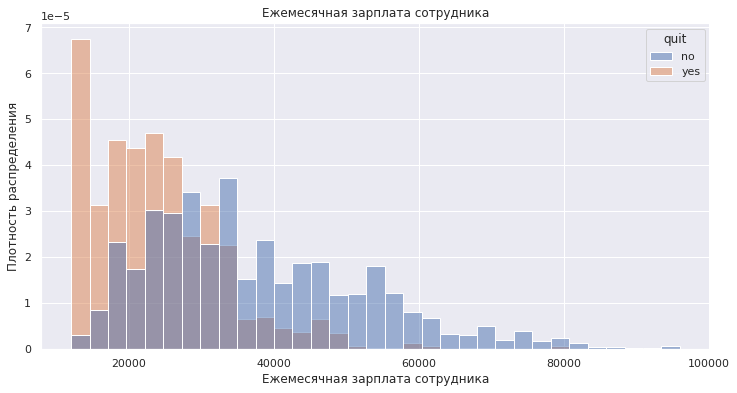

In [130]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=train_quit, x="salary", stat='density', common_norm=False, color="green", label="salary", hue="quit")

plt.ylabel('Плотность распределения')
plt.xlabel('Ежемесячная зарплата сотрудника')
plt.title('Ежемесячная зарплата сотрудника')
#plt.legend() 
plt.show()

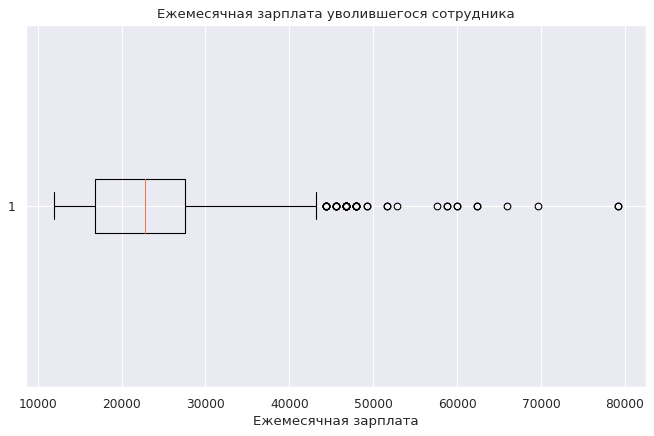

In [131]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(train_quit[train_quit['quit'] == 'yes']['salary'], vert=False)
plt.title('Ежемесячная зарплата уволившегося сотрудника')
plt.xlabel('Ежемесячная зарплата')
plt.show()

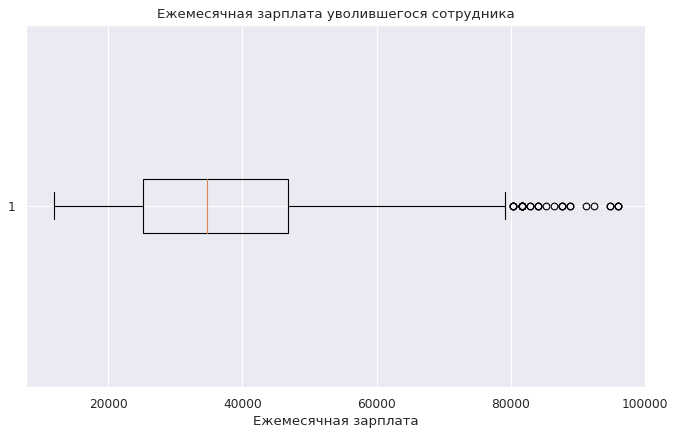

In [132]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(train_quit[train_quit['quit'] == 'no']['salary'], vert=False)
plt.title('Ежемесячная зарплата уволившегося сотрудника')
plt.xlabel('Ежемесячная зарплата')
plt.show()

In [133]:
print('Медианное значение ежемесячной зарплаты уволившегося сотрудника:', round(train_quit[train_quit['quit'] == 'yes']['salary'].median(), 2))

Медианное значение ежемесячной зарплаты уволившегося сотрудника: 22800.0


In [134]:
print('Медианное значение ежемесячной зарплаты неуволившегося сотрудника:', round(train_quit[train_quit['quit'] == 'no']['salary'].median(), 2))

Медианное значение ежемесячной зарплаты неуволившегося сотрудника: 34800.0


Распределение заработной платы не симметричное, максимум сдвинут влево. Наблюдаются выбросы - как для уволившихся, так и для неуволившихся сотрудников. Видно, что медианная зарплата уволившихся сотрудников на 12000 руб. меньше, чем у оставшихся сотрудников.

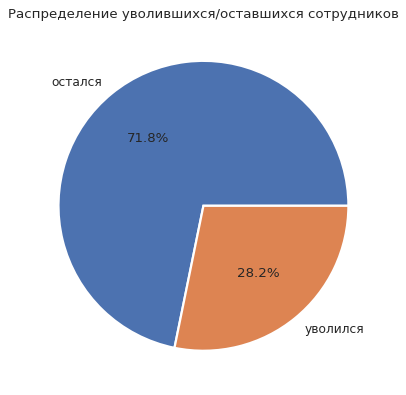

In [135]:
n1 = train_quit[train_quit['quit'] == 'no']['id'].count()
n2 = train_quit[train_quit['quit'] == 'yes']['id'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['остался', 'уволился'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение уволившихся/оставшихся сотрудников')
plt.show()

Соотношение оставшихся/уволившихся сотрудников - 72%/28%. 

Портрет уволившегося сотрудника.
Работает в отделах sales или technology. Занимает должность junior с низким уровнем загруженности. Его не повышали в течение последнего года. Он имел нарушения трудового договора за последний год. Работает в компании первый год. Оценка качества работы такого сотрудника, которую дал руководитель – тройка. Медианное значение ежемесячной зарплаты уволившегося сотрудника: 22800 руб.

In [136]:
data_target = test_features.merge(test_target, on='id').merge(test_target_quit, on='id')

In [137]:
data_target

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.56,yes
1996,109582,technology,middle,low,3,no,no,2,21600,0.14,yes
1997,305653,technology,junior,low,1,no,no,3,14400,0.11,yes
1998,160233,technology,middle,low,8,no,no,1,32400,0.43,no


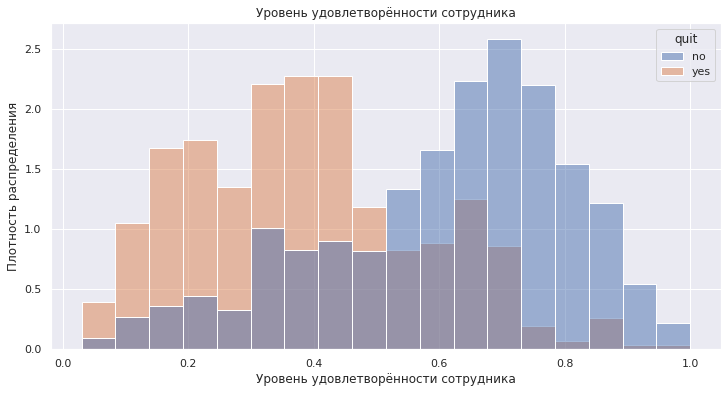

In [138]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=data_target, x="job_satisfaction_rate", stat='density', common_norm=False, color="green", label="salary", hue="quit")

plt.ylabel('Плотность распределения')
plt.xlabel('Уровень удовлетворённости сотрудника')
plt.title('Уровень удовлетворённости сотрудника')
#plt.legend() 
plt.show()

Из сравнения распределений видно, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Наиболее частый уровень уволившегося сотрудника - 0,4, а оставшегося - 0,7.

In [139]:
satisf_quit_yes = data_target[data_target['quit'] == 'yes']['job_satisfaction_rate']

In [140]:
satisf_quit_no = data_target[data_target['quit'] == 'no']['job_satisfaction_rate']

У нас имеется две независимые выборки: уровень удволетворенности для сотрудников, которые остаются и для тех, кто уволился. Нулевая гипотеза формулируется, как «истинные средние этих двух ГС (генеральных совокупностей) равны». Дисперсии обеих ГС считаем равными. В качестве альтернативной гипотезы считаем, что истинное среднее ГС, из которой взяли первую выборку (удволетворенность для оставшихся), больше, чем истинное среднее ГС, из которой взяли вторую (удволетворенность для уволившихся) Для проверки гипотез используем метод для независимых выборок st.ttest_ind со значением параметра alternative = 'greater'

In [141]:
print('Среднее первой выборки (satisf_quit_no)', satisf_quit_no.mean())
print('Среднее второй выборки (satisf_quit_yes)', satisf_quit_yes.mean())

Среднее первой выборки (satisf_quit_no) 0.6120403899721449
Среднее второй выборки (satisf_quit_yes) 0.38771276595744686


In [142]:
alpha = 0.05

results = st.ttest_ind(
    satisf_quit_no,
    satisf_quit_yes,
    alternative = 'greater')

print('р-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение: 6.155610332585965e-105
Отвергаем нулевую гипотезу


Таким образом, по результатам статистического теста отвергаем при уровне статистической значимости, равном 5%, нулевую гипотезу о равенстве исинных средних двух ГС (удволетворенности для тех, кто остался и тех, кто уволился). Более вероятной считаем альтернативную гипотезу о том, что удволетворенность для оставшихся, больше, чем для уволившихся.

Исследовательский анализ данных показал следующее.

Портрет уволившегося сотрудника. Работает в отделах sales или technology. Занимает должность junior с низким уровнем загруженности. Его не повышали в течение последнего года. Он имел нарушения трудового договора за последний год. Работает в компании первый год. Оценка качества работы такого сотрудника, которую дал руководитель – тройка. Медианное значение ежемесячной зарплаты уволившегося сотрудника: 22800 руб.

Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Наиболее частый уровень уволившегося сотрудника - 0,4, а оставшегося - 0,7.

### Шаг 4. Добавление нового входного признака

Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [143]:
X2 = train_quit.drop(['id'], axis=1)

In [144]:
y_pred2 = best_model.predict(X2)

In [145]:
train_quit['job_satisfaction_rate'] = y_pred2

In [146]:
train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.605000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.326667
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.790000
...,...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no,0.528571
3996,672059,sales,middle,high,9,no,no,4,52800,no,0.836000
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.517500
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no,0.553333


### Шаг 5. Подготовка данных

Разделим, как и в первой задаче признаки на числовые, категориальные и порядковые. Признак supervisor_evaluation не будем специально обрабатывать. Целевой признак закодируем при помощи LabelEncoder().

Будем выбирать лучшую модель среди DecisionTreeClassifier, KNeighborsClassifier(), LogisticRegression и SVC().

In [147]:
num_col1 = ['employment_years', 'salary', 'job_satisfaction_rate']
cat_col1 = ['dept', 'last_year_promo', 'last_year_violations']
ord_col1 = ['level', 'workload']

In [148]:
data_1 = train_quit.drop('id', axis=1)

In [149]:
data_1.duplicated().sum()

1413

In [150]:
data_1 = data_1.drop_duplicates().reset_index(drop=True)

In [151]:
data_1.duplicated().sum()

0

In [152]:
encoder = LabelEncoder()

In [153]:
X1_train = data_1.drop(['quit'], axis=1)
y1_train = data_1['quit']

In [154]:
y1_train = encoder.fit_transform(y1_train)

In [155]:
# создаём пайплайн для подготовки признаков из списка cat_col: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

In [156]:
# cоздаём пайплайн для подготовки признаков из списка ord_col: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [157]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col1),
        ('ord', ord_pipe, ord_col1),
        ('num', StandardScaler(), num_col1)
    ], 
    remainder='passthrough'
)

In [158]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    #словарь для модели SVC()
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf']
    }
]

In [159]:
randomized_search2 = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

### Шаг 6. Обучение модели

In [160]:
randomized_search2.fit(X1_train, y1_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(s...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 7),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__kernel': ['linear', 'rbf']}],
                   random_state=42, scoring='roc_auc')

In [161]:
print('Лучшая модель и её параметры:\n\n', randomized_search2.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [162]:
print ('Метрика лучшей модели на кросс-валидации:', randomized_search2.best_score_)

Метрика лучшей модели на кросс-валидации: 0.9070166541622221


In [163]:
X3 = test_features.drop(['id'], axis=1)

In [164]:
X3

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,marketing,junior,medium,2,no,no,5,28800
1,hr,junior,medium,1,no,no,4,30000
2,sales,middle,low,5,no,no,4,19200
3,sales,middle,low,6,no,no,4,19200
4,hr,middle,medium,5,no,no,5,40800
...,...,...,...,...,...,...,...,...
1995,marketing,junior,low,3,no,no,3,20400
1996,technology,middle,low,3,no,no,2,21600
1997,technology,junior,low,1,no,no,3,14400
1998,technology,middle,low,8,no,no,1,32400


In [165]:
y_pred3 = best_model.predict(X3)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Добавим к тестовой выборке job_satisfaction_rate, предсказанный лучшей моделью в первой задаче. После чего добавим в датафрейм целевой признак путем объединения таблиц по id.

In [166]:
test_features['job_satisfaction_rate'] = y_pred3

In [167]:
data_test_quit = test_features.merge(test_target_quit, on='id')

In [168]:
data_test_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.885000,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.682222,no
2,467458,sales,middle,low,5,no,no,4,19200,0.643333,no
3,418655,sales,middle,low,6,no,no,4,19200,0.655000,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.812500,no
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.516000,yes
1996,109582,technology,middle,low,3,no,no,2,21600,0.133333,yes
1997,305653,technology,junior,low,1,no,no,3,14400,0.195000,yes
1998,160233,technology,middle,low,8,no,no,1,32400,0.550000,no


In [169]:
y1_test = data_test_quit['quit']

Закодируем целевой признак при помощи LabelEncoder().

In [170]:
y1_test = encoder.transform(y1_test)

In [171]:
y1_test

array([0, 0, 0, ..., 1, 0, 0])

In [172]:
# рассчитаем прогноз на тестовых данных
y_test_pred1 = randomized_search2.predict_proba(test_features) 

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [173]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y1_test, y_test_pred1[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.9129365949544637


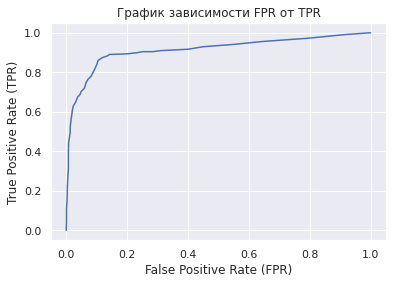

In [174]:
fpr, tpr, threshold = roc_curve(y1_test, y_test_pred1[:, 1], pos_label=1)
plt.plot(fpr, tpr)
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

В результате подбора модели и параметров оказалось, что лучшее значение показала модель KNeighborsClassifier(n_neighbors=47). Метрика ROC-AUC на кросс-валидации равна 0.91, на тестовой - 0.91.

Таким образом, к тренировочной выборке был добавлен признак job_satisfaction_rate, предсказанный лучшей моделью первой задачи.
Для предсказания целевого признака quit выбирали лучшую модель среди DecisionTreeClassifier, KNeighborsClassifier(), LogisticRegression и SVC().
Лучшей оказалась модель ближайших соседей - KNeighborsClassifier(n_neighbors=47).
Метрика ROC-AUC для лучшей модели на тренировочной выборке составила 0.91, на тестовой – 0,91

**Дополнение** Попробуем использовать SelectKBest() для отбора признаков.

Чтобы отобрать признаки, наиболее важные для модели, используем SelectKBest несколько раз с помощью цикла. 

In [175]:
# Лучшая модель из RandomizedSearchCV
model = randomized_search2.best_estimator_.named_steps['models']

In [176]:
# Предобработка данных
preprocessor = randomized_search2.best_estimator_.named_steps['preprocessor']
X_train_pre = preprocessor.transform(X1_train)
X_test_pre = preprocessor.transform(test_features)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [177]:
col_names = preprocessor.get_feature_names_out().tolist()

In [178]:
# Создаем DataFrame с соответствующими именами колонок
X_train_pre_df = pd.DataFrame(X_train_pre, columns=col_names)
X_test_pre_df = pd.DataFrame(X_test_pre, columns=col_names)

In [179]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

In [180]:
roc = []

Подберем количество лучших признаков для модели KNeighborsClassifier(). Выведем количество признаков, значение переменной roc_auc, при разном количестве признаков. 

In [181]:
for i in range(len(col_names)):
    selector = SelectKBest(mutual_info_classif, k=i+1)
    selector.fit(X_train_pre_df, y1_train)
    
    features_names = selector.get_feature_names_out()
    
    X_train_new = X_train_pre_df[features_names]
    X_test_new = X_test_pre_df[features_names]

    
    model.fit(X_train_new, y1_train)

    roc_auc = roc_auc_score(y1_test, model.predict_proba(X_test_new)[:, 1])
    roc.append(roc_auc)
    print(features_names, roc_auc)

['num__job_satisfaction_rate'] 0.7816327614136983
['ord__level' 'num__job_satisfaction_rate'] 0.8843770372784924
['ord__level' 'num__employment_years' 'num__job_satisfaction_rate'] 0.9029786246271163
['ord__level' 'num__employment_years' 'num__salary'
 'num__job_satisfaction_rate'] 0.9151245085837333
['ord__level' 'num__employment_years' 'num__salary'
 'num__job_satisfaction_rate' 'remainder__supervisor_evaluation'] 0.9084095152018016
['ord__level' 'ord__workload' 'num__employment_years' 'num__salary'
 'num__job_satisfaction_rate' 'remainder__supervisor_evaluation'] 0.9193052509927102
['ohe__last_year_promo_yes' 'ord__level' 'ord__workload'
 'num__employment_years' 'num__salary' 'num__job_satisfaction_rate'
 'remainder__supervisor_evaluation'] 0.9197417224757503
['ohe__last_year_promo_yes' 'ohe__last_year_violations_yes' 'ord__level'
 'ord__workload' 'num__employment_years' 'num__salary'
 'num__job_satisfaction_rate' 'remainder__supervisor_evaluation'] 0.9191830142831743
['ohe__dept_ma

In [182]:
roc

[0.7816327614136983,
 0.8843770372784924,
 0.9029786246271163,
 0.9151245085837333,
 0.9084095152018016,
 0.9193052509927102,
 0.9197417224757503,
 0.9191830142831743,
 0.9163678658211344,
 0.915708528418183,
 0.9147473033841048,
 0.9129365949544637]

Наилучшее значение метрики ROC-AUC 0.9217 на тестовой выборке достигается при использовании моделью пяти признаков: ['ord__level' 'ord__workload' 'num__employment_years' 'num__salary'
 'num__job_satisfaction_rate'].

### Шаг 7. Выводы

Для исследования нам даны три датафрейма: train_quit - тренировочная выборка с характеристиками сотрудников компании; test_features - тестовая выборка с характеристиками сотрудников компании; test_target_quit - с целевым признаком тестовой выборки. С типами данных все в порядке. В некоторых колонках есть пропуски. Размер тестовой выборки в два раза меньше тренировочной, соотношение - нормальное для анализа.

Есть 0.1% пропусков в столбце dept и 0.05% пропусков в столбце level датафрейма test_features. В датафрейме test_target_quit пропущенных значений нет. Истинных дубликатов в представленных датафреймах нет. Строк с повторяющимися id в датафреймах нет. В некоторых столбцах датафрейма test_features имеются пробелы.

Исследовательский анализ данных показал следующее.
Портрет уволившегося сотрудника. Работает в отделах sales или technology. Занимает должность junior с низким уровнем загруженности. Его не повышали в течение последнего года. Он имел нарушения трудового договора за последний год. Работает в компании первый год. Оценка качества работы такого сотрудника, которую дал руководитель – тройка. Медианное значение ежемесячной зарплаты уволившегося сотрудника: 22800 руб.
Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Наиболее частый уровень уволившегося сотрудника - 0,4, а оставшегося - 0,7.

К тренировочной выборке был добавлен признак job_satisfaction_rate, предсказанный лучшей моделью первой задачи.
Для предсказания целевого признака quit выбирали лучшую модель среди DecisionTreeClassifier, KNeighborsClassifier(), LogisticRegression и SVC().
Лучшей оказалась модель ближайших соседей - KNeighborsClassifier(n_neighbors=47).
Метрика ROC-AUC для лучшей модели на тренировочной выборке составила 0.91, на тестовой – 0,91.


## Общий вывод

**Задача 1: предсказание уровня удовлетворённости сотрудника**

Для исследования нам даны три датафрейма: train_job_satisfaction_rate - тренировочная выборка с характеристиками сотрудников компании; test_features - тестовая выборка с характеристиками сотрудников компании; test_target - с целевым признаком тестовой выборки. С типами данных все в порядке. В некоторых колонках есть пропуски. Размер тестовой выборки в два раза меньше тренировочной, соотношение - нормальное для анализа.

Есть 0.15% пропусков в столбце dept датафрейма train_job_satisfaction_rate и 0.1% пропусков в столбце dept и 0.05% пропусков в столбце level датафрейма test_features. В датафрейме test_target пропщенных значений нет. Истинных дубликатов в представленных датафреймах нет. Строк с повторяющимися id в датафреймах нет. В некоторых столбцах датафрейма test_features имеются пробелы.

Исследовательский анализ данных показал следующее. Больше всего сотрудников работает в отделе sales, немного меньше - в technology. Остальные отделы представлены примерно одинаково. Больше всего сотрудников занимают должности junior и middle. В основном, уровень загруженности сотрудников - средний. В основном, за последний год сотрудников не повышали. В большинстве случаев, сотрудники не нарушали трудовой договор. В компании больше всего новичков, но есть и сотрудники, проработавшие больше 8 лет. Видно, что оценка качества работы сотрудника, которую дал руководитель, измеряется по пятибалльной системе. И, в основном, сотрудников оценивают на 4. Распределение заработной платы не симметричное, максимум сдвинут влево. Наблюдаются выбросы - значения больше 75000 руб. Среднеее значение (33927 руб.) немного выше медианного (30000 руб.). Распределение уровня удовлетворённости сотрудника работой в компании - непрерывное, несимметричное, некоторые значения встречаются значительно чаще, чем другие. 

Для установления корреляций между целевым параметром - уровнем удовлетворённости сотрудника работой в компании и остальными признаками использовалась корреляция Phi_K. Была построена матрица корреляций Phi_K. Самая высокая корреляция (коэффициент больше 0.7) между целевым параметром уровнем удовлетворённости сотрудника и оценкой качества работы сотрудника, которую дал руководитель. С остальными признаками корреляция ниже. Следующие два признака с самыми высокими коэффициентами корреляции - нарушения сотрудником трудового договор за последний год и повышения за последний год. Наблюдается высокая корреляция между следующими признаками: между рабочей загрузкой и зарплатой, между уровенем занимаемой должности и зарплатой. Однако коэффициенты корреляции между этими признаками меньше 0.9, следовательно мультиколлинеарности не наблюдается.

Из попарных диаграмм рассеяния видно, что хоть какая то зависимость наблюдается только между уровнем удволетворенности и оценкой качества работы. После разделения данных на две группы по признаку наличия нарушений трудового договора видно, что для нарушающих сотрудников есть зависимость (возможно, квадратичная) между уровнем удволетворенности и зарплатой. Еще наблюдается интересная закономерность: для работников с большим стажем (особенно 10 лет) нет зависимости между уровнем удволетворенности и наличием нарушений. Эти работники могут нарушать трудовой договор и при этом оставаться довольными своей работой. У работников с небольшим стажем все иначе. У них низкая удволетворенность коррелирует с наличием нарушений. Корреляционный анализ показывает, что нет линейной зависимости между целевым и остальными признаками. Это означает, что, скорее всего линейная модель нам не подойдет.

Были обучены две модели: линейная модель LinearRegression() и дерево решений DecisionTreeRegressor(). Подбор параметров осуществлялся при помощи RandomizedSearchCV – для дерева решений. Лучшей оказалась модель – дерево решений с параметрами max_depth=38, max_features=19, min_samples_leaf=2, min_samples_split=6. Метрика SMAPE на кросс-валидации составила 15,2, на тестовой – 13,7. Для линейной модели метрика SMAPE на кросс-валидации составила 25, на тестовой - 27. Анализ важности признаков, показал, что с большим отрывом самым важным оказался признак - supervisor_evaluation. Остальные признаки значительно менее важные, самый неважный признак - dept.


**Задача 2: предсказание увольнения сотрудника из компании**

Для исследования нам даны три датафрейма: train_quit - тренировочная выборка с характеристиками сотрудников компании; test_features - тестовая выборка с характеристиками сотрудников компании; test_target_quit - с целевым признаком тестовой выборки. С типами данных все в порядке. В некоторых колонках есть пропуски. Размер тестовой выборки в два раза меньше тренировочной, соотношение - нормальное для анализа.

Есть 0.1% пропусков в столбце dept и 0.05% пропусков в столбце level датафрейма test_features. В датафрейме test_target_quit пропущенных значений нет. Истинных дубликатов в представленных датафреймах нет. Строк с повторяющимися id в датафреймах нет. В некоторых столбцах датафрейма test_features имеются пробелы.

Исследовательский анализ данных показал следующее.
Портрет уволившегося сотрудника. Работает в отделах sales или technology. Занимает должность junior с низким уровнем загруженности. Его не повышали в течение последнего года. Он имел нарушения трудового договора за последний год. Работает в компании первый год. Оценка качества работы такого сотрудника, которую дал руководитель – тройка. Медианное значение ежемесячной зарплаты уволившегося сотрудника: 22800 руб.
Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Наиболее частый уровень уволившегося сотрудника - 0,4, а оставшегося - 0,7.

К тренировочной выборке был добавлен признак job_satisfaction_rate, предсказанный лучшей моделью первой задачи.
Для предсказания целевого признака quit выбирали лучшую модель среди DecisionTreeClassifier, KNeighborsClassifier(), LogisticRegression и SVC().
Лучшей оказалась модель ближайших соседей - KNeighborsClassifier(n_neighbors=47).
Метрика ROC-AUC для лучшей модели на кросс-валидации составила 0.91, на тестовой – 0,91.
Наилучшее значение метрики ROC-AUC 0.9217 на тестовой выборке достигается при использовании моделью пяти признаков: ['ord__level' 'ord__workload' 'num__employment_years' 'num__salary'
 'num__job_satisfaction_rate'].

Таким образом, проведенное исследование показало, что удовлетворённость работой напрямую влияет на отток сотрудников, и для сохранения ценных кадров необходимо поддерживать удволетворенность работой сотрудников на высоком уровне. Самым главным фактором, влияющим на уровень удволетворенности и на то, уволится сотрудник или нет, является оценка качества работы сотрудника, которую дал руководитель. То есть, следует уделять внимание системе оценок сотрудников, возможно, сделать систему оценок более гибкой: увеличить диапазон оценок, и чаще их обновлять. В общем, если требуется сохранить сотрудника, надо повысить ему оценку, даже если он не очень заслуживает этого) Так же важно регулярно повышать ценных сотрудников и поднимать им зарплату. И, как это ни странно, не снижать уровень загрузки.